In [1]:
from CPlantBox_PiafMunch import * #import all the libraries

In [13]:
name = "small_2020.xml"
plant = pb.Plant()

# # 2. A split pot experiment
# topBox = pb.SDF_PlantBox(22, 20, 5)
# #topBox = pb.SDF_RotateTranslate(topBox, pb.Vector3d(0, 0, 5))
# # sideBox = pb.SDF_PlantBox(12, 12, 35)
# # left = pb.SDF_RotateTranslate(sideBox, pb.Vector3d(-6.5, 0, -5))
# # right = pb.SDF_RotateTranslate(sideBox, pb.Vector3d(6.5, 0, -5))
# sideBox = pb.SDF_PlantBox(10, 20, 35)
# left = pb.SDF_RotateTranslate(sideBox, pb.Vector3d(-6, 0, -5))
# right = pb.SDF_RotateTranslate(sideBox, pb.Vector3d(6, 0, -5))
# box_ = []
# box_.append(topBox)
# box_.append(left)
# box_.append(right)
# splitBox = pb.SDF_Union(box_)


# # Set geometry: rotatedRhizotron, splitBox, or rhizoTube
# plant.setGeometry(splitBox)
#plant.write("splitBox.py")
plant.openXML("../../modelparameter/plant/" + name)
seeds = plant.getOrganRandomParameter(pb.OrganTypes.seed)
roots = plant.getOrganRandomParameter(pb.OrganTypes.root)
stems = plant.getOrganRandomParameter(pb.OrganTypes.stem)
leafs = plant.getOrganRandomParameter(pb.OrganTypes.leaf)
plant.initialize(True)


carbon_logger = []
growth_rate_logger = []
exudation_logger = []
root_length_logger = []
all_length_logger = []
taproot_n_all = []
k1_logger = []
leaf_logger = []
dict_leaf_logger = []
vml = 0.000143136 

day_i = 0

In [17]:
# growth rate percentage based on water potential: y = 20.790289211055025 + 83.59701538925951e* **(x*1.3957803144484557)
g_propotion = lambda water_potential : (20.79 + 83.597* 2.71828**(1.39578* (water_potential)) )/100
# absolute respiration maintenance of plant segment = volumen of the segment * 0.0032
# TODO to see if some other parameters from the output can be used as input
# carbon feedback loop by days.
for i in range(1,2): # i*days to simulation
    day_i = day_i +1
#     plant.setGeometry(splitBox)
    day = 1 # the step of every loop (day)
    hour =24 # the hours of every loop (hour) used in PiafMunch
    plant.simulate(day) # start simulation
    organ = plant.getOrgans()
    ana = pb.SegmentAnalyser(plant)
    ana.write("{}{}{}.vtp".format("only_Q_ST_test",str(name),day_i*day)) #writes vtp the name is followed by the number of days simulated
   
    # plant.write("{}{}{}.py".format(hour,str(name),"1st_test"))
    dict_all  = convert( plant ) # convert plant to python outputs
    nodes_cor = python_nodes(plant)
    segs = np.array([np.array(s) for s in plant.getSegments()])
    node_connection_o = segs
    
    
    piafmunch_outputname = name +".ini" # set the name of the parameters
    Soil_water = [0]*(len(dict_all['node_connection'])+1) # initiate soil water potentil
    Seg_radius = [0]*((len(organ))) # initiate the radius of each segment
    k1 = [0]*(len(dict_all['node_connection'])+1) # k1 parameter in equation
    kt = [0]*(len(dict_all['node_connection'])+1) # total carbon maintenance
    node_id_to_organ = [0]*plant.getNumberOfNodes() #
    

    k = 0
    ########################################## python nodes conversion #########################################
    
    nodes_organtype = dict_all['nodes_organtype']
    # sink nodes (nodes have one connection and on the right hand side)
    N1R_node = nodes_organtype[(nodes_organtype[:,1] ==2 ) & (nodes_organtype[:,2] ==1 )] # remove seed. get roots with one connection
    # source nodes
    N1L_node = nodes_organtype[ ((nodes_organtype[:,1] ==4)|(nodes_organtype[:,1] ==3)  ) & (nodes_organtype[:,2] ==1 )] # remove seed. get stem or leaf with one connection
    leaf_logger.append(len(N1L_node)) 
    
    ########################## nodewise iteration to know which organ it belongs to ###########################################
    ########################## nodewise iteration to get maximal  ###########################################  
    for k in reversed(range(len(organ))):  # loop through all the organs
        Seg_radius[k] = organ[k].getParam().a #the diameter of one organ
        j=0
        for j in range(1,organ[k].getNumberOfNodes()): # loop through all segments in one organs
            node_id_to_organ[organ[k].getNodeId(j)]=k # set an id, so we can get the organ number from a node number
            
            volumn = Seg_radius[k]**2*3.1415926* organ[k].getOrganRandomParameter().dx
            phloem_per_section = 1#4200
            m_r = 0.0032 # Organ maintenance respiration rate (gCO2 g−1 DM)
            mass_per_volumn = 0.10 #root dry mass per unit volume (gDM cm−3) 0.05-0.14
            Carbon_main = volumn *0.0032*0.1/(24)/ (1000/12) # (1000/12) from g to mmol calculate the maintenance by volume 4200 is the number of phloem (mmol)
            #Carbon_main = 1
            # print("maintenance is : ", Carbon_main) # absolute carbon maintentance
            k1[organ[k].getNodeId(j)] = Carbon_main 
    k1_logger.append(np.sum(k1))
    taproot_length = [0] * (len(plant.getOrgans())-2)
    all_organ_length = [0] * (len(plant.getOrgans())-2)
    taproot_n = []
    for root_n, root in enumerate(plant.getOrgans()): # recrusive get all the roots
        if root.organType() == 2 and root.getParent().organType()==1: #make sure it is taproot
            taproot_n.append(root_n)
    taproot_n_all.append(taproot_n)
             ############################# water potential in left and right !root! ##################################################
    for j,organ_i in enumerate(plant.getOrgans()): # get all segments in one organs
        print(j, organ_i.organType())
        if j == taproot_n[0] or organ_i.getParent().getId() == 1: # first taproot
            Soil_water[j] = 0.1
        elif j == taproot_n[1] or organ_i.getParent().getId() == 2:
            Soil_water[j] = 0.1
        elif j == taproot_n[2] or organ_i.getParent().getId() == 3:
            Soil_water[j] = 0.1 
        else:
            Soil_water[j] = 0.1
        
        
        
        
    ############################# water potential in left and right !boxex! ##################################################
#     for i, roottip in enumerate(N1R_node): 
#         if left.getDist(plant.getNodes()[int(roottip[0])-1]) <0: # if it is in the left box
#             Soil_water[i] = 0.1 # unit is added with a minus sign, actuall value is -0.2
#         elif right.getDist(plant.getNodes()[int(roottip[0])-1]) <0: # if it is in the right box
#             Soil_water[i] = 0.1 # actuall value is -0.5
#         else:
#             Soil_water[i] = 0.1 # actuall value is -0.1
    
    nodes_length = np.zeros(len(nodes_cor))
    for i in range(1,len(nodes_cor)):
        if nodes_cor[i][1]==2: #if the organtype is root
            nodes_length[i] = nodes_length[node_connection_o[(node_connection_o[:,1] == i)][0][0]] - ((nodes_cor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][3]-nodes_cor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][3])**2 + (nodes_cor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][4]-nodes_cor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][4])**2 + (nodes_cor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][5]-nodes_cor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][5])**2)**(0.5) 
        else:
            nodes_length[i] = nodes_length[node_connection_o[(node_connection_o[:,1] == i)][0][0]] + ((nodes_cor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][3]-nodes_cor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][3])**2 + (nodes_cor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][4]-nodes_cor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][4])**2 + (nodes_cor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][5]-nodes_cor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][5])**2)**(0.5) 

    
    axial_r_xylem = []
    for i in range(0,(len(dict_all["node_connection"]))):
        if plant.getOrgans()[node_id_to_organ[i+1]].getParent().getOrganRandomParameter().subType == 0:
            axial_r_xylem.append(
               k_to_r(k_primary(max(0 ,plant.getOrgans()[node_id_to_organ[i+1]].getLength() - np.abs(nodes_length[i+1])*100))))
        else:
            axial_r_xylem.append( k_to_r(k_lateral(plant.getSegmentCTs()[i])) )
    
    def devide_20(x):
        return x/20
    
    axial_r_xylem_0_25cm = map(devide_20, axial_r_xylem)
    ################################# coupling layer with piafmunch ###################################################
    homo_st = [1]*(len(dict_all["node_connection"]))
    # pass the absolute carbon maintentance to piafmunch
    write_PiafMunch_parameter(dict_all['node_connection'], dict_all['nodes_organtype'], homo_st, dict_all['unq_cnt'], Soil_water, k1, piafmunch_outputname,hour, list(axial_r_xylem_0_25cm), vml)
    # call piafmunch and rename the output file of the PiafMunch
    os.system(' /mnt/c/prog_sct.bas/programs/C++/PIAFMunch2/projects/PIAFMunch2.exe {} -noGUI -q'.format(piafmunch_outputname))
    now = datetime.datetime.now()
    os.system('mv ./{}_{}-{:02}-{:02}*output.txt  ./{}_output.txt'.format(name, now.year ,now.month, now.day,name ) )
    
    ########################## convert carbon to growth rate ###########################################
    piaf_output = read_output(name,  dict_all["node_connection"])
    one_growth_log = [0] * (len(plant.getOrgans())+1)
    one_carbon_log = [0] * (len(plant.getOrgans())+1)
    one_exudation_log = [0] * (len(plant.getOrgans())+1)
    for node_i,root_node in enumerate(N1R_node): # CPlantBox growth rate: cm day-1
        # print(i)
        nodes_organ = organ[node_id_to_organ[int(root_node[0])-1]]
        corss_area_root= nodes_organ.getParam().a**2*3.1415926 # this is also the carbon used for growth because mass need is 1 g DM cm−3
        # carbon_need = # mass need is 1 g DM cm−3
        # print("corss section area of root", corss_area_root)
        # carbon_content = piaf_output["Q_ST"][-1][int(node[0])-1]* 12/1000 * 10 * volumn # directly pass the Q_ST * 1e5 to carbon content
        num_of_phloem = 4200/0.12566370400000001
        carbon_available = piaf_output["Q_ST"][-1][int(root_node[0])-1]
        carbon_content = piaf_output["Q_ST"][-1][int(root_node[0])-1]* 12/1000 *24 *num_of_phloem /0.1/0.2
        print("available carbon: ", carbon_available )
        print(node_id_to_organ[int(root_node[0])-1])
        
        
        
        rw_satis = g_propotion(0-Soil_water[node_i])
        if exudation_logger == []:
            r_water =  rw_satis * nodes_organ.getParam().r
        
        print("rw satisfactory", r_water)
        # nodes_organ.getParam().r =   max([0, min([water_potential ,carbon_content])] )
        r_carbon =  carbon_content/r_water
        nodes_organ.getParam().r =   max([0, min([r_water, carbon_content])])
        
        print("growth rate", nodes_organ.getParam().r)
        one_carbon_log[node_id_to_organ[int(root_node[0])-1]] = carbon_available
        one_growth_log[node_id_to_organ[int(root_node[0])-1]] = nodes_organ.getParam().r
        one_exudation_log[node_id_to_organ[int(root_node[0])-1]] = max([0 ,carbon_content - r_water])  
  #  print(plant.getSeed().getNumberOfChildren())
    growth_rate_logger.append(one_growth_log)
    carbon_logger.append(one_carbon_log)
    exudation_logger.append(one_exudation_log)
    ############################################length logger ###########################
    

    
    for root_n, root in enumerate(plant.getOrgans()): # recrusive get all the roots
        if root.organType() == 2 and root.getParent().organType()==1: #make sure it is taproot: 
            taproot_length[root_n] = root.getLength()
            all_organ_length[root_n] = root.getLength()
        elif root.organType() == 2 and root.getParent().organType()!=1: #make sure it is taproot: 
            # print("lateral",root.getParent().organType() ,  root_n)
            # print(root.getParent().getId())
            taproot_length[taproot_n[root.getParent().getId()-1]] = taproot_length[taproot_n[root.getParent().getId()-1]] +root.getLength()
            all_organ_length[root_n] = root.getLength()
    root_length_logger.append(taproot_length)
    all_length_logger.append(all_organ_length)
#     f=np.sum
    
#     f.plot(piaf_output["Q_ST"][:,int(N1R_node[0][0]-1)], color = "red", label = "1st root")
#     f.plot(piaf_output["Q_ST"][:,int(N1R_node[1][0]-1)], color = "blue", label = "2nd root")
#     f.plot(piaf_output["Q_ST"][:,int(N1R_node[2][0]-1)], color = "green", label = "3rd root")
#     f.legend()
#     f.show()
#     print(piaf_output["Q_ST"][-1,int(N1R_node[0][0]-1)])
#     print(piaf_output["Q_ST"][-1,int(N1R_node[1][0]-1)])
#     print(piaf_output["Q_ST"][-1,int(N1R_node[2][0]-1)])
 # growthrate() CPlantBox growth rate: cm day-1
#total length two curve with total water potential

#change the soil water


0 2
1 2
2 2
3 3
4 4
output successful
available carbon:  8.7712e-06
0
rw satisfactory 1.8699284573082775
growth rate 1.8699284573082775
available carbon:  8.76825e-06
1
rw satisfactory 1.8699284573082775
growth rate 1.8699284573082775
available carbon:  8.75992e-06
2
rw satisfactory 1.8699284573082775
growth rate 1.8699284573082775


In [ ]:
segs = np.array([np.array(s) for s in plant.getSegments()])
node_connection_o = segs
nodes_cor = python_nodes(plant)
    

In [ ]:
4200

In [18]:
root_he_c3 = carbon_logger
root_he_l3 = root_length_logger

No handles with labels found to put in legend.
No handles with labels found to put in legend.


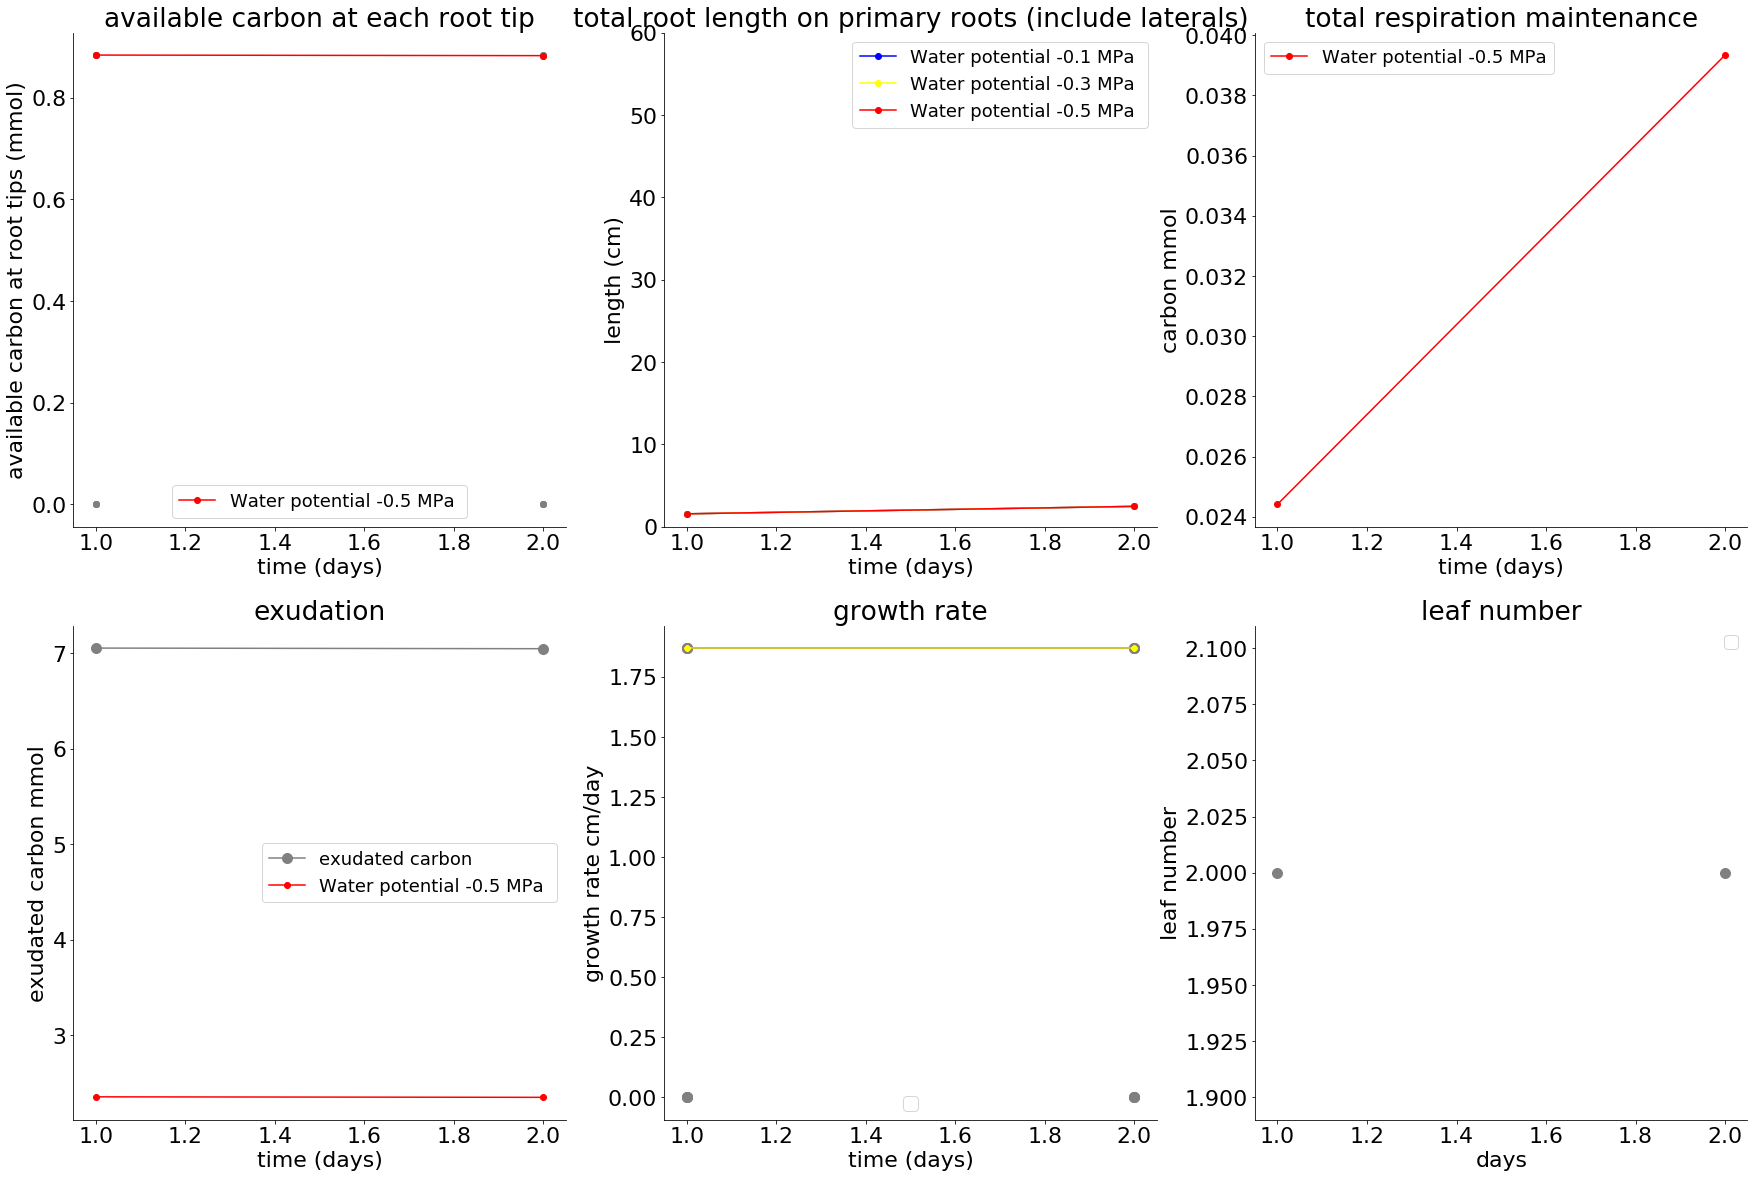

In [19]:
plt.rcParams.update({'font.size': 22})
fig = plt.figure(figsize=(30,20))
a = 2
b = 3
def f2(x):
    return x /12*1000  *0.1*0.2*0.12566370400000001

def f(x):
    # return multiply *4200*24
    return x *4200*24

root_1_l_cf = []
root_1_c_cf = []
root_2_l_cf = []
root_2_c_cf = []
root_3_l_cf = []
root_3_c_cf = []


root_1_c_ec = []
root_2_c_ec = []
root_3_c_ec = []

root_1_c_gr = []
root_2_c_gr = []
root_3_c_gr = []

root_1_c_rr = []
root_2_c_rr = []
root_3_c_rr = []


growth_rate_logger 
exudation_logger 

for i, length_i in enumerate(root_he_l3):
    root_1_l_cf.append(length_i[np.array(root_he_l3[i]).nonzero()[0][0]])
    root_2_l_cf.append(length_i[np.array(root_he_l3[i]).nonzero()[0][1]])
    root_3_l_cf.append(length_i[np.array(root_he_l3[i]).nonzero()[0][2]])
    root_1_c_cf.append(root_he_c3[i][np.array(root_he_l3[i]).nonzero()[0][0]])
    root_2_c_cf.append(root_he_c3[i][np.array(root_he_l3[i]).nonzero()[0][1]])
    root_3_c_cf.append(root_he_c3[i][np.array(root_he_l3[i]).nonzero()[0][2]])
    
    root_1_c_gr.append(growth_rate_logger[i][np.array(root_he_l3[i]).nonzero()[0][0]])
    root_2_c_gr.append(growth_rate_logger[i][np.array(root_he_l3[i]).nonzero()[0][1]])
    root_3_c_gr.append(growth_rate_logger[i][np.array(root_he_l3[i]).nonzero()[0][2]])
    
    root_1_c_ec.append(exudation_logger[i][np.array(root_he_l3[i]).nonzero()[0][0]])
    root_2_c_ec.append(exudation_logger[i][np.array(root_he_l3[i]).nonzero()[0][1]])
    root_3_c_ec.append(exudation_logger[i][np.array(root_he_l3[i]).nonzero()[0][2]])
    
    root_1_c_rr.append(all_length_logger[i][np.array(root_he_l3[i]).nonzero()[0][0]])
    root_2_c_rr.append(all_length_logger[i][np.array(root_he_l3[i]).nonzero()[0][1]])
    root_3_c_rr.append(all_length_logger[i][np.array(root_he_l3[i]).nonzero()[0][2]])
    
ax1 = fig.add_subplot(a, b, 1)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("available carbon at root tips (mmol)")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)
ax1.plot(days,f(np.array(root_3_c_cf)), marker = "o", linestyle="-", color = "red", label= "Water potential -0.5 MPa ", zorder=2)
for i, day in enumerate(carbon_logger):
    x = [i+1]*len(day)
    ax1.plot(x,f(np.array(carbon_logger[i])), marker = "o", linestyle="", color = "grey", zorder=1)
ax1.title.set_text("available carbon at each root tip")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
ax1.legend()


ccc = np.squeeze(np.array(all_length_logger))
ax2 = fig.add_subplot(a, b, 2)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.plot(days, root_1_l_cf, color= "blue", marker = "o", label= "Water potential -0.1 MPa ")
ax2.plot(days, root_2_l_cf, color= "yellow", marker = "o", label= "Water potential -0.3 MPa ")
ax2.plot(days, root_3_l_cf, color= "red", marker = "o", label= "Water potential -0.5 MPa")
for i, day in enumerate(all_length_logger):
    x = [i+1]*len(day)
    ax2.plot(x,day, marker = "o", linestyle="", color = "grey", zorder=1, markersize=1)
ax2.legend()
ax2.title.set_text("total root length on primary roots (include laterals)")
ax2.set_xlabel("time (days)")
ax2.set_ylabel("length (cm)")
ax2.set_ylim([0,60])
#ax2.set_xlim([0,120])
fig.savefig(fname= 'length2 ')





ax3 = fig.add_subplot(a, b, 3)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
# ax2.plot(days, root_1_l_cf, color= "blue", marker = "o", label= "Water potential -0.1 MPa ")
# ax2.plot(days, root_2_l_cf, color= "red", marker = "o", label= "Water potential -0.3 MPa ")

ax3.plot(days, f(np.array(k1_logger)), color= "red", marker = "o", label= "Water potential -0.5 MPa")
ax3.legend()
ax3.title.set_text("total respiration maintenance")
ax3.set_xlabel("time (days)")
ax3.set_ylabel("carbon mmol")
#ax3.set_ylim([0,60])
#ax3.set_xlim([0,120])
fig.savefig(fname= 'length2 ')

total_exudation = []
for i, root_tip in enumerate(exudation_logger):
    total_exudation.append(np.sum(root_tip))

ax4 = fig.add_subplot(a, b, 4)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
# ax2.plot(days, root_1_l_cf, color= "blue", marker = "o", label= "Water potential -0.1 MPa ")
# ax2.plot(days, root_2_l_cf, color= "red", marker = "o", label= "Water potential -0.3 MPa ")

# for i, root_tip in enumerate(exudation_logger):
#     x = [i+1]*len(root_tip)
ax4.plot(days,total_exudation , marker = "o", linestyle="-", color = "grey", zorder=1, markersize=10, label = "exudated carbon")
#ax4.plot(days,np.array(root_1_c_ec), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax4.plot(days,np.array(root_2_c_ec), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)
ax4.plot(days,np.array(root_3_c_ec), marker = "o", linestyle="-", color = "red", label= "Water potential -0.5 MPa ", zorder=2)

ax4.legend()
ax4.title.set_text("exudation")
ax4.set_xlabel("time (days)")
ax4.set_ylabel("exudated carbon mmol")
# ax4.set_ylim([0,10])
#ax4.set_xlim([0,120])
fig.savefig(fname= 'length2 ')


for i, root_tip in enumerate(exudation_logger):
    total_exudation.append(np.sum(root_tip))

ax5 = fig.add_subplot(a, b, 5)
ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)
# ax2.plot(days, root_1_l_cf, color= "blue", marker = "o", label= "Water potential -0.1 MPa ")
# ax2.plot(days, root_2_l_cf, color= "red", marker = "o", label= "Water potential -0.3 MPa ")

for i, root_tip in enumerate(growth_rate_logger):
    x = [i+1]*len(root_tip)
    ax5.plot(x,root_tip , marker = "o", linestyle="", color = "grey", zorder=1, markersize=10)
ax5.legend()
ax5.title.set_text("growth rate")
ax5.set_xlabel("time (days)")
ax5.set_ylabel("growth rate cm/day")
# ax5.set_ylim([0,10])
#ax4.set_xlim([0,120])

ax5.plot(days,np.array(root_1_c_gr), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
ax5.plot(days,np.array(root_2_c_gr), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)
ax5.plot(days,np.array(root_3_c_gr), marker = "o", linestyle="-", color = "red", label= "Water potential -0.5 MPa ", zorder=2)


ax6 = fig.add_subplot(a, b, 6)
ax6.spines['right'].set_visible(False)
ax6.spines['top'].set_visible(False)
# ax2.plot(days, root_1_l_cf, color= "blue", marker = "o", label= "Water potential -0.1 MPa ")
# ax2.plot(days, root_2_l_cf, color= "red", marker = "o", label= "Water potential -0.3 MPa ")

ax6.plot(days,leaf_logger , marker = "o", linestyle="", color = "grey", zorder=1, markersize=10)
ax6.legend()
ax6.title.set_text("leaf number")
ax6.set_xlabel("days")
ax6.set_ylabel("leaf number")
# ax5.set_ylim([0,10])
#ax4.set_xlim([0,120])
fig.savefig(fname= 'length2 ')

In [12]:
    def devide_20(x):
        x = x/20
        return x
    axial_r_xylem_0_25cm = map(devide_20, axial_r_xylem)

In [14]:
list(axial_r_xylem_0_25cm)

[0.0006925560460462999,
 0.0007088900163433915,
 0.0007260130723424564,
 0.0007439838098977531,
 0.0007628667737209279,
 0.0007827332319771257,
 0.0007888035574242544,
 0.0006925560460462999,
 0.0007088900163433915,
 0.0007260130723424564,
 0.0007439838098977531,
 0.0007628667737209279,
 0.0007827332319771257,
 0.0007888035574242544,
 0.0006925560460462999,
 0.0007088900163433915,
 0.0007260130723424566,
 0.0007439838098977531,
 0.0007628667737209279,
 0.0007827332319771257,
 0.0007888035574242546,
 0.0006103156454056713,
 0.0006229652307039277,
 0.0006361502722340107,
 0.0006499055038858342,
 0.0013295341816930097,
 0.0009593352115461898,
 0.0009445026880677533,
 0.0006642687300924291,
 0.0006792811728006079,
 0.0006949878665786513,
 0.0008100626863085721,
 0.0008257408630645141,
 0.0008490670493927103,
 0.0008737494197100399,
 0.0008766528176965379,
 0.0008100626863085722,
 0.0008257408630645143,
 0.0008490670493927104,
 0.0008737494197100399,
 0.0008766528176965379,
 0.0008100626863

array([[ 1,  2],
       [ 2,  3],
       [ 3,  4],
       [ 4,  5],
       [ 5,  6],
       [ 6,  7],
       [ 7,  8],
       [ 1,  9],
       [ 9, 10],
       [10, 11],
       [11, 12],
       [12, 13],
       [13, 14],
       [14, 15],
       [ 1, 16],
       [16, 17],
       [17, 18],
       [18, 19],
       [19, 20],
       [20, 21],
       [21, 22],
       [23,  1],
       [24, 23],
       [25, 24],
       [26, 25],
       [30, 26],
       [31, 30],
       [32, 31],
       [27, 26],
       [28, 27],
       [29, 28]], dtype=int32)

##Length of each connection

The connections are stored in *node_connection* list. Every element of the list is a two number list. The first element of this two numbered list is the first connected node and the second element of this two numbered list is the second connected node.

In [103]:
node_c_length[np.amin(node_connection[0])-1] 

0

In [91]:
(nodes_cor[np.amax(node_connection[i])-1][3]-nodes_cor[np.amin(node_connection[i])-1][3])**2 

2.719511964312267e-07

In [125]:
node_c_length=[]
node_c_length = [0] * (len(node_connection) +1)

In [126]:
i=0
for i, connection in enumerate(node_connection):
    node_c_length[i+1] = node_c_length[np.amin(node_connection[i])-1] + ((nodes_cor[np.amax(node_connection[i])-1][3]-nodes_cor[np.amin(node_connection[i])-1][3])**2 + (nodes_cor[np.amax(node_connection[i])-1][4]-nodes_cor[np.amin(node_connection[i])-1][4])**2 + (nodes_cor[np.amax(node_connection[i])-1][5]-nodes_cor[np.amin(node_connection[i])-1][5])**2)**(0.5) 


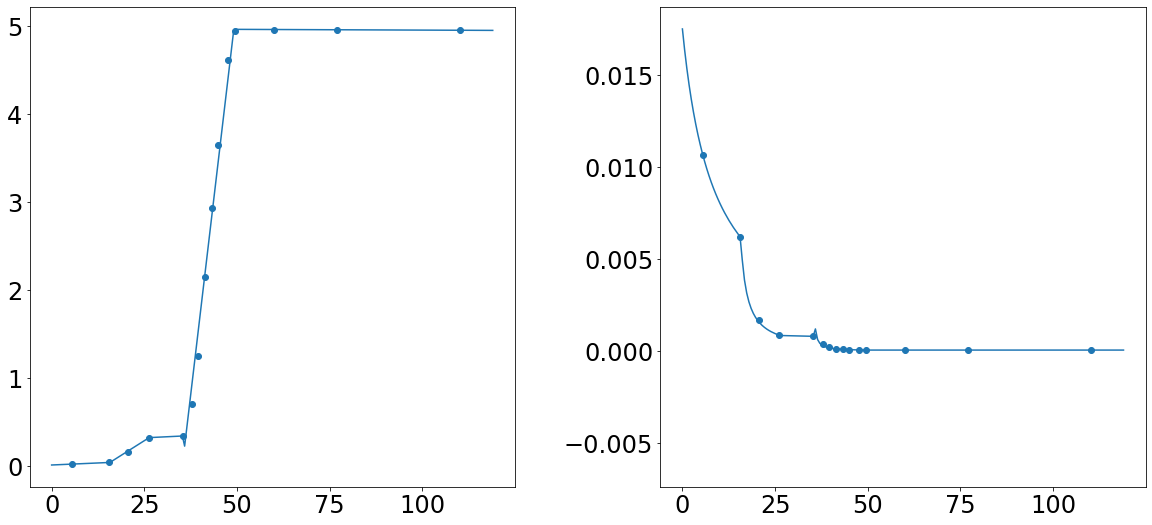

In [3]:
plt.rcParams['figure.figsize'] = [20, 30]
plt.rcParams.update({'font.size': 24})
f = plt.figure()
plt.rcParams.update({'legend.fontsize': 18})
f.subplots_adjust(wspace=0.3)

x_axis_cm = [
5.506136884, 
15.55448305, 
20.57316414, 
26.18098606,
35.34262534,
37.98477221,
39.43565633,
41.46070314,
43.19517371,
44.93363844,
47.69361348,
49.59883503,
59.94275016,
77.08574995,
110.1894737,]

y_axis_r_primary = [
0.02602038694,
0.04459330144,
0.1653671729,
0.3265820678,
0.3453047639,
0.7097233202,
1.256775536,
2.148325359,
2.938572914,
3.647738714,
4.620245475,
4.944247972,
4.962770959,
4.959875182,
4.954283337,  
]

ax = plt.subplot(321)

ax.scatter(x_axis_cm, y_axis_r_primary)
# primary_r_interval = [0, 15, 35, ] 
def k_primary(x):
    if x < 15.55:
        return 0.001848355360491469*x+0.015843089314858807
    elif 26.18> x >= 15.55 :
        return 0.0265794629572805*x-0.3731958224157048
    elif 35.34> x >= 26.18 :
        return 0.0020435967328327315*x +0.2730786902254447
    elif 49.59> x >= 35.34 :
        return 0.35677667926196793*x -12.57081093520535
    elif 120> x >= 49.59 :
        return -0.00016891891420869065*x +4.9728964232362864 

#     from conductivity to resistance from m^4 s^-1 MPa^-1 x 10^9  to  MPa h ml^-1 /5 cm
def k_to_r(k): 
    return 10e-9 *100*100*100*100 /3600/k
    
x = np.linspace(0,119,200)
y = np.zeros(200)
for i in range (0,len(x)):
    y[i] = k_primary(x[i])

ax.plot(x, y)


ax = plt.subplot(322)

yc2 = np.zeros(len(x_axis_cm))
for i in range (0,len(x_axis_cm)):
    yc2[i] = k_to_r(y_axis_r_primary[i])

ax.scatter(x_axis_cm,yc2)
x = np.linspace(0,119,200)
y2 = np.zeros(200)
for i in range (0,len(x)):
    y2[i] = k_to_r((k_primary(x[i])))

ax.plot(x, y2)

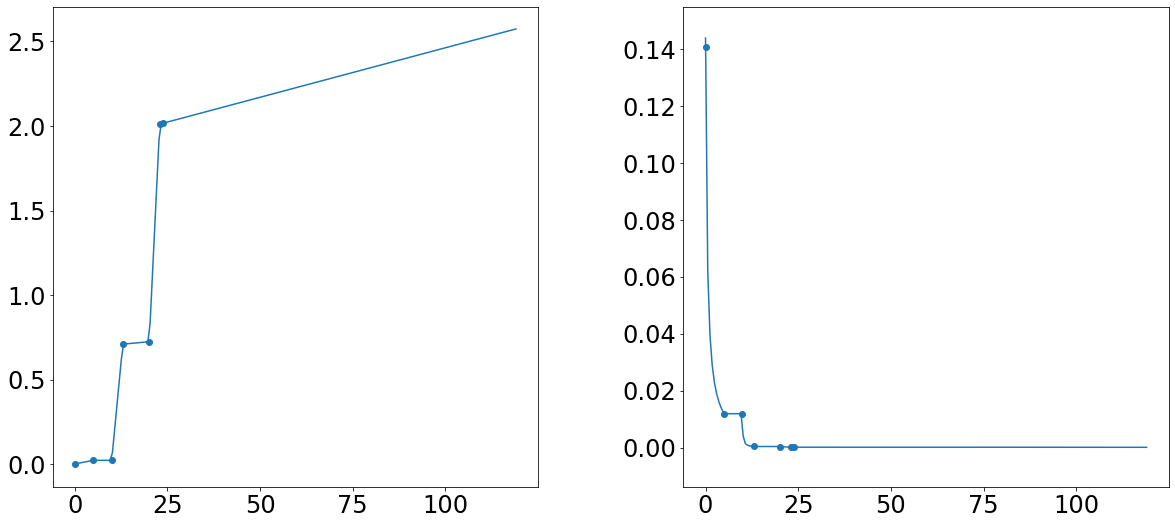

In [4]:
plt.rcParams['figure.figsize'] = [20, 30]
plt.rcParams.update({'font.size': 24})
f = plt.figure()
plt.rcParams.update({'legend.fontsize': 18})
f.subplots_adjust(wspace=0.3)

x_axis_day = [
0.009810055459,
5.020713492,
9.963766575,
12.95495271,
20.08446367,
22.92530994,
23.92745418,]

y_axis_r_lateral = [
0.001971122598,
0.0233102711,
0.02327989941,
0.710208532,
0.7246776045,
2.011526056,
2.017393866,  
]

ax = plt.subplot(321)

ax.scatter(x_axis_day, y_axis_r_lateral)
# primary_r_interval = [0, 15, 35, ] 
def k_lateral(x):
    if x < 5:
        return 0.004258543149115853*x+0.0019293460538895271
    elif  9.96> x >= 5:
        return 0.0000019478470310608697*x+0.02330049151582271
    elif 12.95> x >= 9.96 :
        return 0.22965091485084213*x -2.2649082099802036
    elif 20> x >= 12.95 :
        return 0.0020294621328947786*x + 0.6839169460538098
    elif 23> x >= 20 :
        return 0.45298067054396246*x +-8.373196214574355 
    elif  x >= 23 :
        return 0.005855255182446519*x +1.877292516018327

#     from conductivity to resistance from m^4 s^-1 MPa^-1 x 10^9  to  MPa h ml^-1 /5 cm
def k_to_r(k): 
    return 10e-9 *100*100*100*100 /3600/k
    
x = np.linspace(0,119,200)
y = np.zeros(200)
for i in range (0,len(x)):
    y[i] = k_lateral(x[i])

ax.plot(x, y)


ax = plt.subplot(322)

yc2 = np.zeros(len(x_axis_day))
for i in range (0,len(x_axis_day)):
    yc2[i] = k_to_r(y_axis_r_lateral[i])

ax.scatter(x_axis_day,yc2)
x = np.linspace(0,119,200)
y2 = np.zeros(200)
for i in range (0,len(x)):
    y2[i] = k_to_r((k_lateral(x[i])))

ax.plot(x, y2)

In [361]:
y

array([ 1.92934605e-03,  4.47591206e-03,  7.02247806e-03,  9.56904407e-03,
        1.21156101e-02,  1.46621761e-02,  1.72087421e-02,  1.97553081e-02,
        2.23018741e-02,  4.62195855e-02,  4.87661516e-02,  5.13127176e-02,
        5.38592836e-02,  5.64058496e-02,  5.89524156e-02,  6.14989816e-02,
        6.40455476e-02, -2.26488841e+00, -2.26488724e+00, -2.26488608e+00,
       -2.26488491e+00, -2.26488375e+00,  7.10616101e-01,  7.11829699e-01,
        7.13043297e-01,  7.14256895e-01,  7.15470493e-01,  7.16684091e-01,
        7.17897689e-01,  7.19111287e-01,  7.20324885e-01,  7.21538483e-01,
        7.22752081e-01,  7.23965679e-01,  8.36651992e-01,  1.10752988e+00,
        1.37840777e+00,  1.64928566e+00,  1.92016355e+00,  2.01384648e+00,
        2.01734787e+00,  2.02084925e+00,  2.02435063e+00,  2.02785202e+00,
        2.03135340e+00,  2.03485478e+00,  2.03835617e+00,  2.04185755e+00,
        2.04535894e+00,  2.04886032e+00,  2.05236170e+00,  2.05586309e+00,
        2.05936447e+00,  

In [146]:
nodes_length = np.zeros(len(nodes_cor))
for i in range(1,len(nodes_cor)):
    if nodes_cor[i][1]==2: #if the organtype is root
        nodes_length[i] = nodes_length[node_connection_o[(node_connection_o[:,1] == i)][0][0]] - ((nodes_cor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][3]-nodes_cor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][3])**2 + (nodes_cor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][4]-nodes_cor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][4])**2 + (nodes_cor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][5]-nodes_cor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][5])**2)**(0.5) 
    else:
        nodes_length[i] = nodes_length[node_connection_o[(node_connection_o[:,1] == i)][0][0]] + ((nodes_cor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][3]-nodes_cor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][3])**2 + (nodes_cor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][4]-nodes_cor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][4])**2 + (nodes_cor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][5]-nodes_cor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][5])**2)**(0.5) 


In [208]:
nodes_length

array([ 0.        , -0.0025    , -0.005     , -0.0075    , -0.01      ,
       -0.0125    , -0.015     , -0.01573877, -0.0025    , -0.005     ,
       -0.0075    , -0.01      , -0.0125    , -0.015     , -0.01573877,
       -0.0025    , -0.005     , -0.0075    , -0.01      , -0.0125    ,
       -0.015     , -0.01573877,  0.0025    ,  0.005     ,  0.0075    ,
        0.01      ,  0.0125    ,  0.015     ,  0.0156446 ,  0.0125    ,
        0.015     ,  0.016484  ])

In [204]:
for i, node_l in enumerate(nodes_length):
#     print(plant.getOrgans()[node_id_to_organ[i]].getOrganRandomParameter().subType)
    print(plant.getOrgans()[node_id_to_organ[i]].getOrganRandomParameter().organType)

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
4
4
4
3
3
3


In [220]:
for i in range(0,(len(node_connection)+1)):    
    print(plant.getOrgans()[node_id_to_organ[i]].getLength()/100) 

0.01573877361149466
0.01573877361149466
0.01573877361149466
0.01573877361149466
0.01573877361149466
0.01573877361149466
0.01573877361149466
0.01573877361149466
0.01573877361149466
0.01573877361149466
0.01573877361149466
0.01573877361149466
0.01573877361149466
0.01573877361149466
0.01573877361149466
0.01573877361149466
0.01573877361149466
0.01573877361149466
0.01573877361149466
0.01573877361149466
0.01573877361149466
0.01573877361149466
0.016483997698218032
0.016483997698218032
0.016483997698218032
0.016483997698218032
0.005644596350456717
0.005644596350456717
0.005644596350456717
0.016483997698218032
0.016483997698218032
0.016483997698218032


In [372]:
axial_r_xylem = []
for i in range(0,(len(node_connection))):
    if plant.getOrgans()[node_id_to_organ[i+1]].getParent().getOrganRandomParameter().subType == 0:
        axial_r_xylem.append(
           k_to_r(k_primary(max(0 ,plant.getOrgans()[node_id_to_organ[i+1]].getLength() - np.abs(nodes_length[i+1])*100))))
    else:
        axial_r_xylem.append( k_to_r(k_lateral(plant.getSegmentCTs()[i])) )

In [373]:
axial_r_xylem

[0.015187341981924243,
 0.015580986961768947,
 0.015995580913346026,
 0.016432841842439615,
 0.016894680890546736,
 0.017383230259740548,
 0.017533056353930758,
 0.015187341981924243,
 0.015580986961768947,
 0.015995580913346026,
 0.016432841842439615,
 0.01689468089054674,
 0.017383230259740548,
 0.017533056353930758,
 0.015187341981924243,
 0.015580986961768947,
 0.015995580913346026,
 0.016432841842439615,
 0.016894680890546736,
 0.017383230259740548,
 0.017533056353930758,
 0.015073820003056751,
 0.015461527045992586,
 0.01586970468609054,
 0.01630001812884391,
 0.05564333457628032,
 0.04850628168861509,
 0.04489055454368261,
 0.016754318224451118,
 0.01723466808018101,
 0.017533056353930758]

In [200]:
len(to_tip_distance)

32

In [183]:
plant.getOrgans()[1].getChild(0).getAge()

-1.772588722239781

In [184]:
plant.getOrgans()[1].getChild(1).getAge()

-3.4786449012756373

In [201]:
plant.getSegmentCTs()

[0.12907704227514236,
 0.26706278524904525,
 0.415278729556489,
 0.5753641449035618,
 0.7493868988828214,
 0.9400072584914712,
 1.0,
 0.12907704227514236,
 0.26706278524904525,
 0.415278729556489,
 0.5753641449035618,
 0.7493868988828214,
 0.9400072584914712,
 1.0,
 0.12907704227514236,
 0.26706278524904525,
 0.415278729556489,
 0.5753641449035618,
 0.7493868988828214,
 0.9400072584914712,
 1.0,
 0.12823323596887645,
 0.26340128914456573,
 0.40629732374443733,
 0.5578588782855243,
 0.7192051811294522,
 0.8916873598468311,
 0.9999999999999999,
 0.7359007351182211,
 0.9414349748878987,
 0.9999999999999999]

In [199]:
len(plant.getSegmentCTs())
len(plant.getNodes())
# help(plant)
# help(plant.getOrgans()[1].getChild())

32

findfont: Font family ['Comic Sans MS'] not found. Falling back to DejaVu Sans.


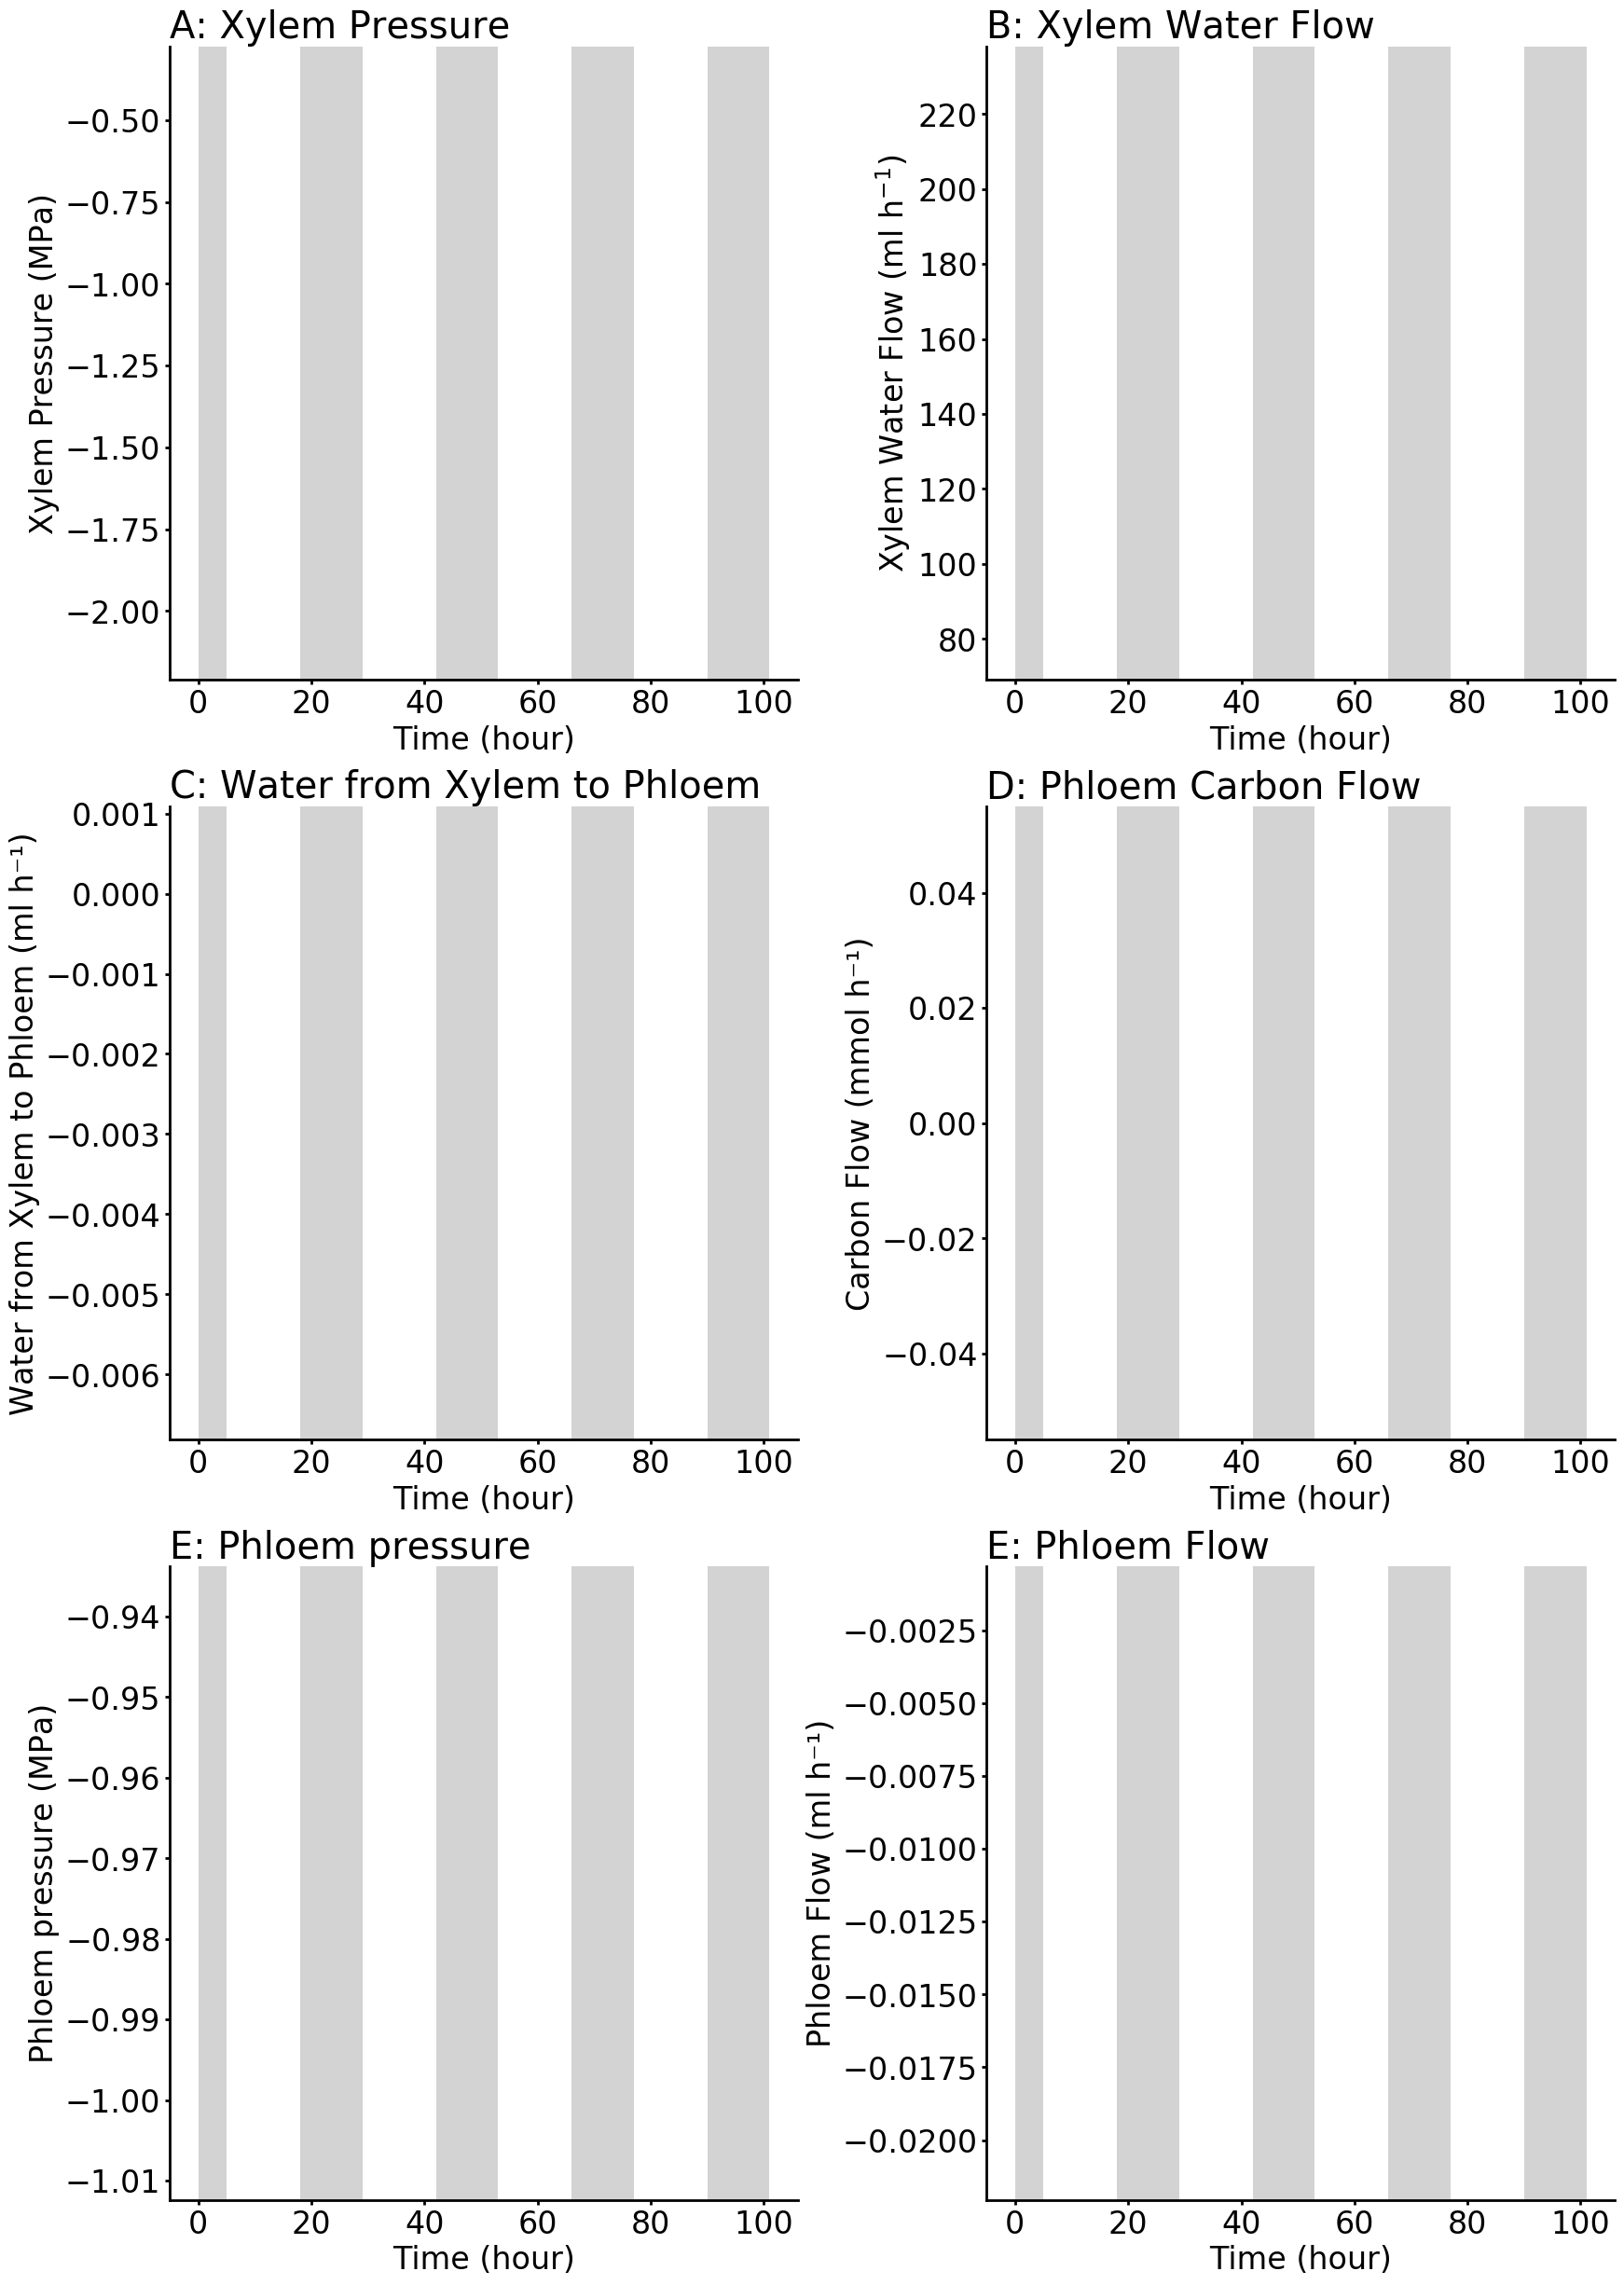

In [9]:
def add_day_night():
    #trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
    #ax.fill_between(x, np.min(y), np.max(y), where=[ 12<x<18] , facecolor='lightgrey', alpha=1, interpolate=False,zorder=0,transform=trans)
    for i in range(0,4):
        ax.axvspan(0,5,facecolor='lightgrey', zorder=0)
        ax.axvspan(18+24*i,29+24*i,facecolor='lightgrey',zorder=0)
        
plt.style.use('default')
x=piaf_output["time"]
lable_size=16
title_size =24

def line_style(int): #set line style in the plot figure
    if  i ==1 : #int is a small part of main stem which are shown in dashed line 
        return ':'
    else: #
        return '-'
stem_line = mlines.Line2D([], [], color='darkgreen', marker='', linestyle='-', linewidth= 5,
                          markersize=30, label='Stem')
root_line = mlines.Line2D([], [], color='wheat', marker='', linestyle='-', linewidth= 5,
                          markersize=30, label='Root')
leaf_line = mlines.Line2D([], [], color='lightgreen', marker='', linestyle='-', linewidth= 5,
                          markersize=30, label='Leaf')
stem_line1 = mlines.Line2D([], [], color='darkgreen', marker='', linestyle=':', linewidth= 5,
                          markersize=30, label='Stem\n between\n two\n leaves')


csfont = {'fontname':'Comic Sans MS'}
hfont = {'fontname':'Comic Sans MS'}

plt.rcParams['figure.figsize'] = [20, 30]
plt.rcParams.update({'font.size': 24})
f = plt.figure()
plt.rcParams.update({'legend.fontsize': 18})
f.subplots_adjust(wspace=0.3)

node_connection =dict_all['node_connection']

stem_nodes = nodes_organtype[(nodes_organtype[:,1]== 2)][:,0] 
root_nodes = nodes_organtype[(nodes_organtype[:,1]== 1)][:,0] 
leaf_nodes = nodes_organtype[(nodes_organtype[:,1]== 3)][:,0] 

all_marker_1 =[3, 10, 17, 23,28, 31,]
    
def organ_color(int):
    if i == 28 or i == 31: #int is source 
        return 'lightgreen'
    elif i == 3 or i == 10 or i == 17: #int is sink
        return 'wheat'
    elif i == 23:
        return 'darkgreen'
    else:
        return 'None'    

def organ_color_n(int):
    if i == 28 or i == 31: #int is source 
        return 'lightgreen'
    elif i == 3 or i == 10 or i == 17: #int is sink
        return 'wheat'
    elif i == 23:
        return 'darkgreen'
    else:
        return 'None'       
time = piaf_output["time"]

ax = plt.subplot(321)
ax.tick_params(width=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
plt.xlabel("Time (hour)")
plt.ylabel("Xylem Pressure (MPa)", color='black')
#plt.ylabel("Xylem water flow (ml h$^{-1}$)".format(output.columns[n_begin]))
#plt.title("{}th figure {} ".format(i ,output.columns[n_begin]))
plt.title("A: Xylem Pressure", color='black' ,loc="left")
#plt.title("Xylem Water Flow with Constant Transpiration".format(i ,output.columns[n_begin]))
for i in all_marker_1:
    ax.plot(x,piaf_output["P_Xyl"].T[i], linewidth=5
                ,c=organ_color(i),alpha=0.8,zorder=0, ls = line_style(i))
add_day_night()








ax = plt.subplot(322)
ax.tick_params(width=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
plt.xlabel("Time (hour)")
plt.ylabel("Xylem Water Flow (ml h$^{-1}$)")
plt.title("B: Xylem Water Flow",loc="left")
#plt.title("Xylem Water Flow with Constant Transpiration".format(i ,output.columns[n_begin]))
for i in all_marker_1:
    ax.plot(x,piaf_output["JW_Xyl"].T[np.where(node_connection[:,0] == i)[0][0]], linewidth=5
                ,c=organ_color(i),alpha=0.8,zorder=0, ls = line_style(i))
# plt.ylim((-0.0001, 0.0005))
# plt.xlim((15, 32))
add_day_night()


ax = plt.subplot(323)
ax.tick_params(width=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
plt.xlabel("Time (hour)", **hfont)
plt.ylabel('Water from Xylem to Phloem (ml h⁻¹)', color='black')
plt.title('C: Water from Xylem to Phloem', color='black', loc="left")  
for i in all_marker_1:
        ax.plot(x,piaf_output["JW_Trsv"].T[i], linewidth=5,
                c=organ_color_n(i),alpha=0.8, ls = line_style(i))
add_day_night()




ax = plt.subplot(324)
ax.tick_params(width=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)


plt.xlabel("Time (hour)", **hfont)

plt.ylabel('Carbon Flow (mmol h⁻¹)', color='black')
 
plt.title('D: Phloem Carbon Flow', color='black',loc="left")  
for i in all_marker_1:
    ax.plot(x,piaf_output["JS_ST"].T[np.where(node_connection[:,0] == i)[0][0]], linewidth=5
                ,c=organ_color(i),alpha=0.8,zorder=0, ls = line_style(i))
add_day_night()


ax = plt.subplot(325)
ax.tick_params(width=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)


plt.xlabel("Time (hour)", **hfont)

plt.ylabel('Phloem pressure (MPa)', color='black')
 
plt.title('E: Phloem pressure', color='black',loc="left")  
for i in all_marker_1:
    ax.plot(x,piaf_output["P_ST"].T[np.where(node_connection[:,0] == i)[0][0]], linewidth=5
                ,c=organ_color(i),alpha=0.8,zorder=0, ls = line_style(i))
add_day_night()

ax = plt.subplot(326)
ax.tick_params(width=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)


plt.xlabel("Time (hour)", **hfont)

plt.ylabel('Phloem Flow (ml h⁻¹)', color='black')
 
plt.title('E: Phloem Flow', color='black',loc="left")  
for i in all_marker_1:
    ax.plot(x,piaf_output["JW_ST"].T[np.where(node_connection[:,0] == i)[0][0]], linewidth=5
                ,c=organ_color(i),alpha=0.8,zorder=0, ls = line_style(i))
add_day_night()

plt.show()
# s =output.columns[n_begin]
# s = s.replace('/', '')
s = "small_2020"
# f.savefig("diural_homogeneous{}.png".format(s), bbox_inches='tight', dpi=600)



In [66]:
dict_all

{'node_connection': array([[ 1,  2],
        [ 2,  3],
        [ 3,  4],
        [ 4,  5],
        [ 5,  6],
        [ 6,  7],
        [ 7,  8],
        [ 1,  9],
        [ 9, 10],
        [10, 11],
        [11, 12],
        [12, 13],
        [13, 14],
        [14, 15],
        [ 1, 16],
        [16, 17],
        [17, 18],
        [18, 19],
        [19, 20],
        [20, 21],
        [21, 22],
        [23,  1],
        [24, 23],
        [25, 24],
        [26, 25],
        [30, 26],
        [31, 30],
        [32, 31],
        [27, 26],
        [28, 27],
        [29, 28]], dtype=int32),
 'nodes_organtype': array([[ 1.,  2.,  4.,  4.],
        [ 2.,  2.,  2.,  2.],
        [ 3.,  2.,  2.,  2.],
        [ 4.,  2.,  2.,  2.],
        [ 5.,  2.,  2.,  2.],
        [ 6.,  2.,  2.,  2.],
        [ 7.,  2.,  2.,  2.],
        [ 8.,  2.,  1.,  1.],
        [ 9.,  2.,  2.,  2.],
        [10.,  2.,  2.,  2.],
        [11.,  2.,  2.,  2.],
        [12.,  2.,  2.,  2.],
        [13.,  2.,  2.,  2.],

In [33]:
nodes_cor

array([[ 0.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -3.00000000e-02],
       [ 1.00000000e+00,  2.00000000e+00,  2.00000000e+00,
        -3.66809453e-04, -2.38641653e-04, -3.24614022e-02],
       [ 2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
        -5.42874059e-04, -2.32001712e-04, -3.49551859e-02],
       [ 3.00000000e+00,  2.00000000e+00,  2.00000000e+00,
        -8.23245031e-04, -2.24884526e-04, -3.74394044e-02],
       [ 4.00000000e+00,  2.00000000e+00,  2.00000000e+00,
        -1.15362253e-03, -1.67924333e-04, -3.99168237e-02],
       [ 5.00000000e+00,  2.00000000e+00,  2.00000000e+00,
        -1.65510496e-03, -4.14123867e-04, -4.23536046e-02],
       [ 6.00000000e+00,  2.00000000e+00,  2.00000000e+00,
        -1.65678273e-03, -8.39502458e-04, -4.48171488e-02],
       [ 7.00000000e+00,  2.00000000e+00,  2.00000000e+00,
        -1.86826029e-03, -1.13873830e-03, -4.72901501e-02],
       [ 8.00000000e+00,  2.00000000e+00,  2.000

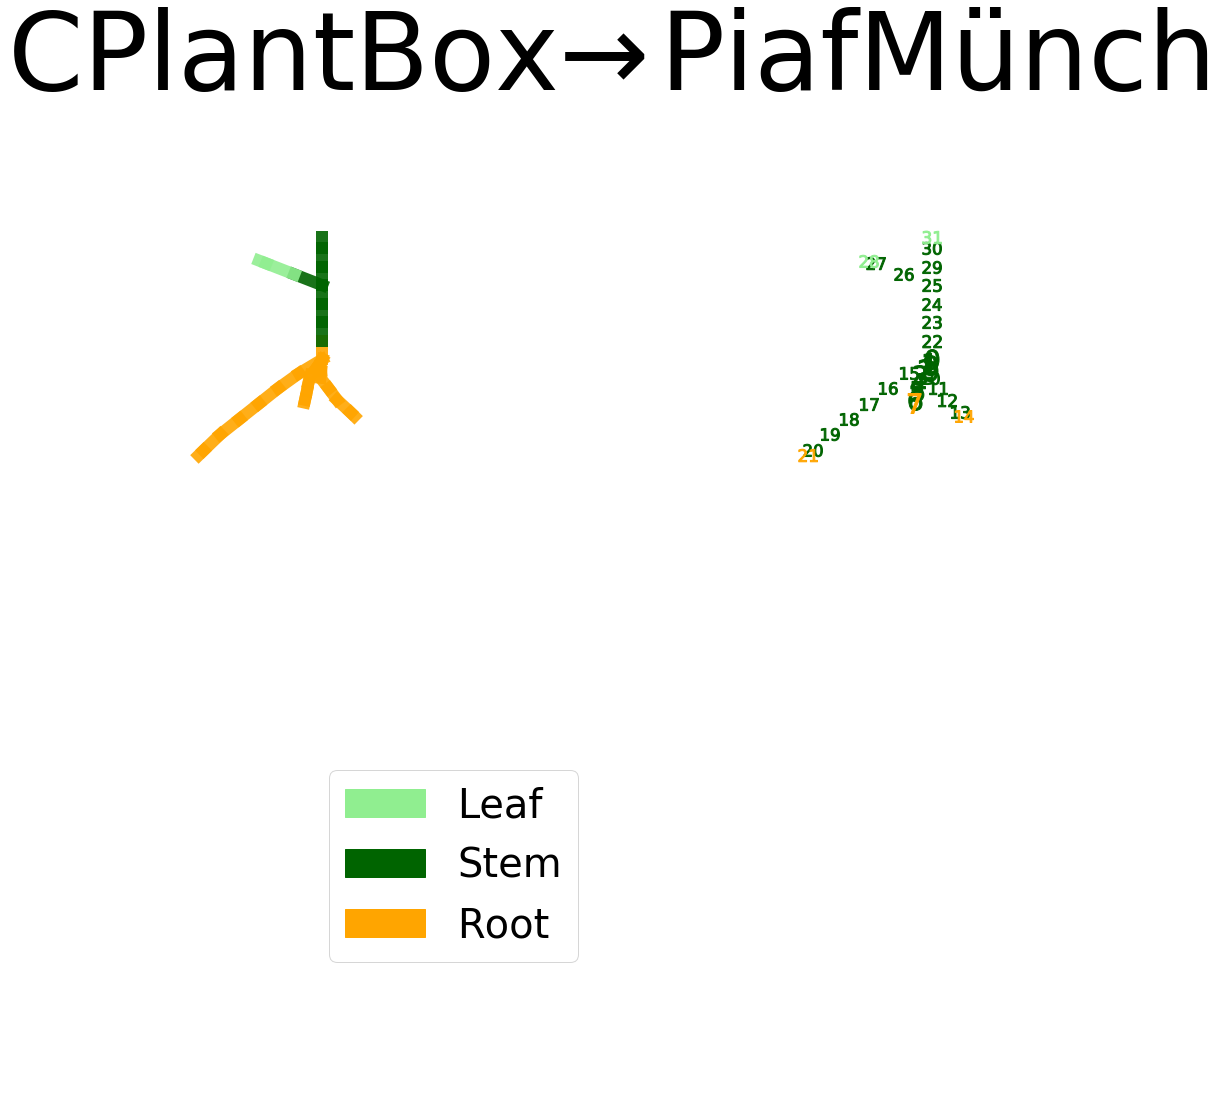

In [17]:

# nodes_cor = np.column_stack([dict_all["nodes_organtype"], dict_all["nodes"]])
nodes_cor = python_nodes(plant)
node_connection = dict_all["node_connection"]
plt.rcParams['figure.figsize'] = [20, 20]

import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt




fig = plt.figure()

ax = fig.add_subplot(122, projection='3d')
plt.rcParams.update({'font.size': 90})
plt.title('PiafMünch')
x =nodes_cor[:,3]*100
y =nodes_cor[:,4]*100
z =nodes_cor[:,5]*100

# Get rid of colored axes planes
# First remove fill
#ax.set_axis_off()
# Get rid of the panes
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# Get rid of the spines
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

# Now set color to white (or whatever is "invisible")
#ax.xaxis.pane.set_edgecolor('w')
#ax.yaxis.pane.set_edgecolor('w')
#ax.zaxis.pane.set_edgecolor('w')


ax.set_xticks([]) 
ax.set_yticks([]) 
ax.set_zticks([])

# Bonus: To get rid of the grid as well:
ax.grid(False)

def so_si_color(int):
    if int in N1L_node[:,0]: #int is source 
        return 'lightgreen'
    elif int in N1R_node[:,0]: #int is sink
        return 'orange'
    else:
        return 'darkgreen'
    


for i in range(len(nodes_cor)):
    ax.plot([x[i]], [y[i]], [z[i]], marker='${}$'.format(i),
            markersize=20, color=so_si_color(i+1), alpha=1)
    #ax.scatter(cor_x[i], cor_y[i],cor_z[i], s=100, marker = organ_marker(node_connection[i,0]) ,edgecolors= organ_color3(i))

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_zlabel('')
ax.set_xlim3d(-1.2, 1)
ax.set_ylim3d(1.5 ,0.5)
ax.set_zlim3d(-8.8,0)

#ax.elev = 89.9
#ax.azim = 270.1
ax.dist = 6.0
#ax.view_init(0, 90)
ax.view_init(0, 90)
stem_nodes = nodes_organtype[(nodes_organtype[:,1]== 3)][:,0] 
root_nodes = nodes_organtype[(nodes_organtype[:,1]== 2)][:,0] 
leaf_nodes = nodes_organtype[(nodes_organtype[:,1]== 4)][:,0] 
#(nodes_organtype[:,1]== 8)|
#print(stem_nodes)



ax = fig.add_subplot(121, projection='3d')
plt.rcParams.update({'font.size': 90})
plt.title('CPlantBox$\u2192$ ')
x =nodes_cor[:,3]*100
y =nodes_cor[:,4]*100
z =nodes_cor[:,5]*100
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# Get rid of the spines
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

ax.set_xticks([]) 
ax.set_yticks([]) 
ax.set_zticks([])

# Bonus: To get rid of the grid as well:
#ax.grid(False)
#for i in range(len(nodes_cor)):
#    ax.plot([x[i]], [y[i]], [z[i]], marker='${}$'.format(nodes_cor[i,1]),
#            markersize=12, color='black')
def organ_color(int):
    if int in leaf_nodes: #int is source 
        return 'lightgreen'
    elif int in root_nodes: #int is sink
        return 'orange'
    elif int in stem_nodes:
        return 'darkgreen'
    else:
        return 'black'

for i in range(len(node_connection)):
    #xline = [x[node_connection[:,0][i]]],[x[node_connection[:,1][i]]] )
    #yline = np.array([y[node_connection[:,0][i]]],[y[node_connection[:,1][i]]] )
    #zline = np.array([z[node_connection[:,0][i]]],[z[node_connection[:,1][i]]] )
    ax.plot3D(np.array([[x[node_connection[:,0][i]-1]][0],[x[node_connection[:,1][i]-1]][0]]), 
              np.array([[y[node_connection[:,0][i]-1]][0],[y[node_connection[:,1][i]-1]][0]]), 
              np.array([[z[node_connection[:,0][i]-1]][0],[z[node_connection[:,1][i]-1]][0]]), 
              color=organ_color(node_connection[i,1]), alpha=0.9, linewidth=12)

    
#ax.scatter([x[715]], [y[715]], [z[715]], c='r', s=99)
#ax.scatter([x[860]], [y[860]], [z[860]], c='g', s=99)
#ax.scatter([x[627]], [y[627]], [z[627]], c='g', s=99)

ax.dist = 6.0
ax.set_xlabel('',labelpad=0)
ax.set_ylabel('',labelpad=0)
ax.set_zlabel('',labelpad=0)
ax.set_xlim3d(-1.2, 1)
ax.set_ylim3d(1.5 ,0.5)
ax.set_zlim3d(-8.8,0)
#ax.xaxis.set_ticks(np.arange(0, 3, 1))
#ax.yaxis.set_ticks(np.arange(0 ,3, 1))
#ax.zaxis.set_ticks(np.arange(-3,2, 1))
plt.rcParams.update({'font.size': 40})
root_patch = mpatches.Patch(color='orange', label='Root')
# seed_patch = mpatches.Patch(color='black', label='seed')
stem_patch = mpatches.Patch(color='darkgreen', label='Stem')
leaf_patch = mpatches.Patch(color='lightgreen', label='Leaf')
plt.legend(handles=[leaf_patch,stem_patch,  root_patch],bbox_to_anchor=(0.5, 0.3), loc=2, borderaxespad=0.)
ax.view_init(0, 90)
plt.show()


fig.savefig("{}.svg".format('CPlantBox_to_PiafMunch'), bbox_inches='tight')

In [55]:
i =5
[x[node_connection[:,0][i]]][0]

-0.9733855198142037

In [46]:
nodes_cor

array([[ 0.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -3.00000000e-02],
       [ 1.00000000e+00,  2.00000000e+00,  2.00000000e+00,
        -3.66809453e-04, -2.38641653e-04, -3.24614022e-02],
       [ 2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
        -5.42874059e-04, -2.32001712e-04, -3.49551859e-02],
       [ 3.00000000e+00,  2.00000000e+00,  2.00000000e+00,
        -8.23245031e-04, -2.24884526e-04, -3.74394044e-02],
       [ 4.00000000e+00,  2.00000000e+00,  2.00000000e+00,
        -1.15362253e-03, -1.67924333e-04, -3.99168237e-02],
       [ 5.00000000e+00,  2.00000000e+00,  2.00000000e+00,
        -1.65510496e-03, -4.14123867e-04, -4.23536046e-02],
       [ 6.00000000e+00,  2.00000000e+00,  2.00000000e+00,
        -1.65678273e-03, -8.39502458e-04, -4.48171488e-02],
       [ 7.00000000e+00,  2.00000000e+00,  2.00000000e+00,
        -1.86826029e-03, -1.13873830e-03, -4.72901501e-02],
       [ 8.00000000e+00,  2.00000000e+00,  2.000

In [20]:
# totla phloem area: 2mm^2,  radius 15 um
2**2 / (0.015**2*3.1415926)

5658.842517574614